In [37]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import seaborn as sns

from sklearn.ensemble import BaggingClassifier


In [38]:
load_dotenv()

# Ambil variabel dari .env
user_postgres = os.getenv("USER_POSTGRES")
password_postgres = os.getenv("PASS_POSTGRES")
host_postgres = os.getenv("HOST_POSTGRES")
port_postgres = os.getenv("PORT_POSTGRES")
db_postgres = os.getenv("DB_POSTGRES")

user_mysql = os.getenv("USER_MYSQL")
password_mysql = os.getenv("PASS_MYSQL")
host_mysql = os.getenv("HOST_MYSQL")
port_mysql = os.getenv("PORT_MYSQL")
db_mysql = os.getenv("DB_MYSQL")


postgres_conn = f"postgresql+psycopg2://{user_postgres}:{password_postgres}@{host_postgres}:{port_postgres}/{db_postgres}"

mysql_conn = f"mysql+pymysql://{user_mysql}:{password_mysql}@{host_mysql}:{port_mysql}/{db_mysql}"

postgres_engine = create_engine(postgres_conn)
postgres_engine = create_engine(mysql_conn)

python-dotenv could not parse statement starting at line 16
python-dotenv could not parse statement starting at line 19


In [39]:
mysql_df_iris = pd.read_sql("SELECT id, class, petal_length, petal_width FROM iris_full", mysql_conn)
postgres_df_iris = pd.read_sql("SELECT id, sepal_length, sepal_width FROM iris_full", postgres_conn)

In [40]:
# mengabungkan 2 database
merge_df = pd.merge(mysql_df_iris, postgres_df_iris, left_on="id", right_on='id', how='outer')

In [41]:
print(merge_df)

      id           class  petal_length  petal_width  sepal_length  sepal_width
0      1     Iris-setosa           1.4          0.2           5.1          3.5
1      2     Iris-setosa           1.4          0.2           4.9          3.0
2      3     Iris-setosa           1.3          0.2           4.7          3.2
3      4     Iris-setosa           1.5          0.2           4.6          3.1
4      5     Iris-setosa           1.4          0.2           5.0          3.6
..   ...             ...           ...          ...           ...          ...
145  146  Iris-virginica           5.2          2.3           6.7          3.0
146  147  Iris-virginica           5.0          1.9           6.3          2.5
147  148  Iris-virginica           5.2          2.0           6.5          3.0
148  149  Iris-virginica           5.4          2.3           6.2          3.4
149  150  Iris-virginica           5.1          1.8           5.9          3.0

[150 rows x 6 columns]


In [42]:
table_iris = merge_df.copy()

## **Menghapus Dataset**

In [43]:
# Ambil semua iris-setosa
setosa = table_iris[table_iris["class"] == "Iris-setosa"]

# Sisakan hanya 15 data pertama
setosa_keep = setosa.head(15)

# Ambil data selain iris-setosa
non_setosa = table_iris[table_iris["class"] != "Iris-setosa"]

# Gabungkan kembali
table_iris = pd.concat([non_setosa, setosa_keep], ignore_index=True)

print(table_iris["class"].value_counts())


class
Iris-versicolor    50
Iris-virginica     50
Iris-setosa        15
Name: count, dtype: int64


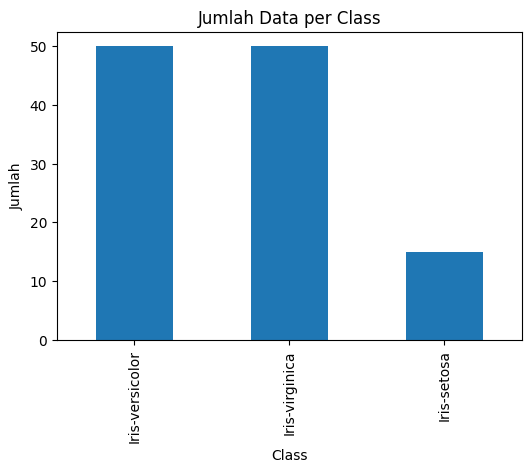

In [44]:
table_iris["class"].value_counts().plot(kind="bar", figsize=(6,4))

plt.title("Jumlah Data per Class")
plt.xlabel("Class")
plt.ylabel("Jumlah")
plt.show()


In [45]:
# Pisahkan fitur (X) dan label (y)
X = table_iris[["sepal_length", "sepal_width", "petal_length", "petal_width"]].values
y = table_iris["class"].astype("category").cat.codes  # convert class ke angka 0,1,2
target_names = table_iris["class"].unique()          # nama class

## **Syntesis Dataset dengan Algoritma SMOTE**

In [46]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Sesudah SMOTE:", Counter(y_res))

# Ubah kembali ke DataFrame agar mudah dianalisis
table_iris_balanced = pd.DataFrame(X_res, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
table_iris_balanced["class"] = [target_names[i] for i in y_res]

print(table_iris_balanced["class"].value_counts())

Sesudah SMOTE: Counter({1: 50, 2: 50, 0: 50})
class
Iris-virginica     50
Iris-setosa        50
Iris-versicolor    50
Name: count, dtype: int64


## **Melakukan Klasifikasi**

In [47]:
print(table_iris["class"].value_counts())

class
Iris-versicolor    50
Iris-virginica     50
Iris-setosa        15
Name: count, dtype: int64


In [48]:
print(table_iris_balanced["class"].value_counts())

class
Iris-virginica     50
Iris-setosa        50
Iris-versicolor    50
Name: count, dtype: int64


### *Dataset Iris Tidak Seimbang*

In [ ]:
class_mapping = table_iris["class"].astype("category").cat.categories.tolist()

In [49]:
X_not_balance = table_iris[["sepal_length", "sepal_width", "petal_length", "petal_width"]].values
y_not_balance = table_iris["class"].astype("category").cat.codes  # convert class ke angka 0,1,2

In [64]:
X_train_not_balance, X_test_not_balance, y_train_not_balance, y_test_not_balance = train_test_split(
    X_not_balance, y_not_balance, test_size=0.2, random_state=42, stratify=y_not_balance
)

#### Bagging Classifier with base model SVM

In [67]:
base_svm = SVC(kernel='rbf', probability=True, random_state=42)

# 3. Bagging dengan SVM
bagging_svm = BaggingClassifier(
    estimator=base_svm,   # pakai SVM
    n_estimators=20,      # jumlah SVM
    max_samples=0.8,      # ambil 80% data tiap estimator
    bootstrap=True,
    random_state=42,
    n_jobs=-1             # paralel supaya lebih cepat
)

# 4. Latih model
bagging_svm.fit(X_train_not_balance, y_train_not_balance)

# 5. Prediksi
y_pred = bagging_svm.predict(X_test_not_balance)

# 6. Evaluasi
print("Akurasi:", accuracy_score(y_test_not_balance, y_pred))
print("\nClassification Report:\n", classification_report(y_test_not_balance, y_pred, target_names=class_mapping))


Akurasi: 1.0

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         3
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        23
      macro avg       1.00      1.00      1.00        23
   weighted avg       1.00      1.00      1.00        23



#### Bagging Classifier with base model Naive Bayes

In [68]:
base_nb = GaussianNB()

# 4. Bagging dengan Naive Bayes
bagging_nb = BaggingClassifier(
    estimator=base_nb,     # base estimator = Naive Bayes
    n_estimators=20,       # jumlah estimator (default 10, di sini coba 20)
    max_samples=0.8,       # ambil 80% data untuk tiap estimator
    bootstrap=True,        # sampling dengan pengembalian (bootstrap)
    random_state=42,
    n_jobs=-1              # paralel supaya lebih cepat
)

# 5. Latih model
bagging_nb.fit(X_train_not_balance, y_train_not_balance)

# 6. Prediksi
y_pred = bagging_nb.predict(X_test_not_balance)

# 7. Evaluasi
print("Akurasi:", accuracy_score(y_test_not_balance, y_pred))


print("\nClassification Report:\n",
      classification_report(y_test_not_balance, y_pred, target_names=class_mapping))

print("\nConfusion Matrix:\n", confusion_matrix(y_test_not_balance, y_pred))

Akurasi: 0.9565217391304348

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         3
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.96        23
      macro avg       0.97      0.97      0.97        23
   weighted avg       0.96      0.96      0.96        23


Confusion Matrix:
 [[ 3  0  0]
 [ 0  9  1]
 [ 0  0 10]]


### *Dataset Iris Seimbang*

In [56]:
class_mapping_balance = table_iris_balanced["class"].astype("category").cat.categories.tolist()

In [57]:
X_balance = table_iris_balanced[["sepal_length", "sepal_width", "petal_length", "petal_width"]].values
y_balance = table_iris_balanced["class"].astype("category").cat.codes  # convert class ke angka 0,1,2

In [61]:
X_train_balance, X_test_balance, y_train_balance, y_test_balance = train_test_split(
    X_balance, y_balance, test_size=0.2, random_state=42, stratify=y_balance
)

#### Bagging Classifier with base model SVM

In [62]:
base_svm = SVC(kernel='rbf', probability=True, random_state=42)

# 3. Bagging dengan SVM
bagging_svm = BaggingClassifier(
    estimator=base_svm,   # pakai SVM
    n_estimators=20,      # jumlah SVM
    max_samples=0.8,      # ambil 80% data tiap estimator
    bootstrap=True,
    random_state=42,
    n_jobs=-1             # paralel supaya lebih cepat
)

# 4. Latih model
bagging_svm.fit(X_train_balance, y_train_balance)

# 5. Prediksi
y_pred = bagging_svm.predict(X_test_balance)

# 6. Evaluasi
print("Akurasi:", accuracy_score(y_test_balance, y_pred))
print("\nClassification Report:\n", classification_report(y_test_balance, y_pred, target_names=class_mapping_balance))


Akurasi: 0.9333333333333333

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       0.90      0.90      0.90        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



#### Bagging Classifier with base model Naive Bayes

In [63]:
base_nb = GaussianNB()

# 4. Bagging dengan Naive Bayes
bagging_nb = BaggingClassifier(
    estimator=base_nb,     # base estimator = Naive Bayes
    n_estimators=20,       # jumlah estimator (default 10, di sini coba 20)
    max_samples=0.8,       # ambil 80% data untuk tiap estimator
    bootstrap=True,        # sampling dengan pengembalian (bootstrap)
    random_state=42,
    n_jobs=-1              # paralel supaya lebih cepat
)

# 5. Latih model
bagging_nb.fit(X_train_balance, y_train_balance)

# 6. Prediksi
y_pred = bagging_nb.predict(X_test_balance)

# 7. Evaluasi
print("Akurasi:", accuracy_score(y_test_balance, y_pred))

print("\nClassification Report:\n",
      classification_report(y_test_balance, y_pred, target_names=class_mapping_balance))

print("\nConfusion Matrix:\n", confusion_matrix(y_test_balance, y_pred))

Akurasi: 0.9666666666666667

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       0.91      1.00      0.95        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      0.90      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30


Confusion Matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 1  0  9]]
